In [1]:
import stat_arb
from stat_arb.model.data_handler.simulated_data_handler import SimulatedDataHandler
import matplotlib.pyplot as plt
import datetime as dt

plt.style.use("seaborn-v0_8")

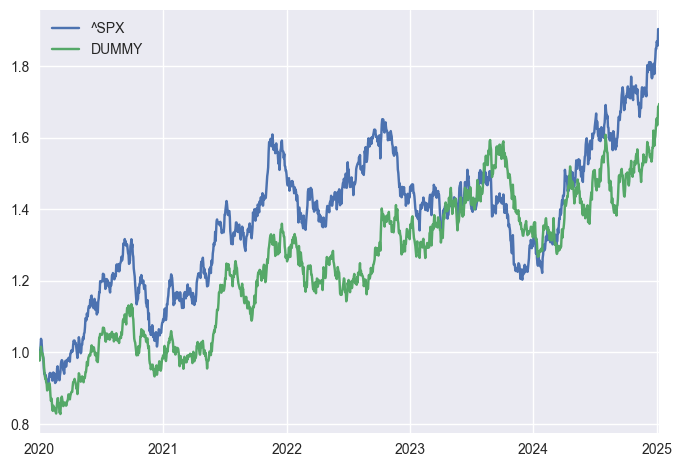

In [69]:
tickers = ["^SPX", "DUMMY"]
start = dt.date(2020, 1, 1)
end = dt.date(2025, 1, 8)
live = dt.date(2025, 1, 6)

data = SimulatedDataHandler(tickers, start, end, corr=0.7)

ts = data.get_normalised_close_prices()

ts.plot();